In [111]:
import numpy as np
from itertools import product
from scipy.optimize import fsolve


class betrand_model(object):

    def __init__(self, **kwargs):
        """Initialize game with default values"""
        # Default properties
        self.numPlayers = 4
        self.alpha = kwargs.get('alpha', 0.15)
        self.beta = kwargs.get('beta', 4e-6)
        self.delta = kwargs.get('delta', 0.95)
        
        self.c = kwargs.get('c', 1)
        self.a = kwargs.get('a', 2)
        self.a0 = kwargs.get('a0', 0)
        self.mu = kwargs.get('mu', 0.25)
        self.penalty = kwargs.get('penalty',-1)
        self.reward = kwargs.get('reward',1)
        self.k = kwargs.get('k',15)
        self.numiActions = self.k
        self.numActions = self.numiActions ** self.numPlayers
        
        self.eps = kwargs.get('eps',0.5)


        # Derived properties
        self.indexActions = self.init_indexActions()

        self.p_minmax_cost_1 = self.compute_p_competitive_monopoly(c = 1)
        self.init_actions()
        
        self.Profits,self.Penalty = self.init_Profits()
        self.Q = self.init_Q()
        self.cActions = self.init_cActions()

        
    def demand(self, p):
        e = np.exp((self.a - p) / self.mu)
        d = e / (np.sum(e) + np.exp(self.a0 / self.mu))
        return d

    
    def foc(self, p, c):
        d = self.demand(p)
        zero = 1 - (p - c) * (1 - d) / self.mu
        return np.squeeze(zero)

    
    def foc_monopoly(self, p, c):
        d = self.demand(p)
        d1 = np.flip(d)
        p1 = np.flip(p)
        zero = 1 - (p - c) * (1 - d) / self.mu + (p1 - c) * d1 / self.mu
        return np.squeeze(zero)
    
    
    def foc1_monopoly(self,p,c):
        zero = -p + c + self.mu*(1+np.exp((self.a-p-self.a0)/self.mu))
        return zero
    def compute_p_monopoly_1(self,c):
        p0 = c
        p_monopoly = fsolve(self.foc1_monopoly,p0,args = (c,))
        return p_monopoly
    
    
    def compute_p_competitive_2(self,c):
        p0 = c
        p_competitive = fsolve(self.foc2_competitive,p0,args = (c,))
        return p_competitive
    def foc2_competitive(self,p,c):
        zero = -p + c + self.mu*(1+1/(1+np.exp((-self.a+p+self.a0)/self.mu)))
        return zero
    
    
    def foc2_monopoly(self,p,c):
        zero = -p + c + self.mu*(1+2*np.exp((self.a-p-self.a0)/self.mu))
        return zero
    def compute_p_monopoly_2(self,c):
        p0 = c
        p_monopoly = fsolve(self.foc2_monopoly,p0,args = (c,))
        return p_monopoly

    
    def compute_p_competitive_monopoly(self, c):

        p_competitive = self.compute_p_competitive_2(c)
        p_monopoly = self.compute_p_monopoly_2(c)
        return p_competitive, p_monopoly

    
    
    def init_actions(self):
        a = np.linspace(min(self.p_minmax_cost_1[0]), max(self.p_minmax_cost_1[1]), self.k - 2)
        delta = a[1] - a[0]
        A = np.linspace(min(a) - delta, max(a) + delta, self.k)
        self.player_actions = A
        self.player_cost = self.player_actions - self.mu*(1+1/(1 + \
                                      np.exp((self.a0-self.a+self.player_actions)/self.mu)))
        self.player_cost[np.abs(self.player_cost-self.c)<1e-5] = self.c
        self.buyer_action_list = A
        self.buyer_cost_list = self.player_cost
        self.seller_action_list = A
        self.seller_cost_list = self.player_cost
        self.buyerbrother_action_list = A
        self.buyerbrother_cost_list = self.player_cost
        self.sellerbrother_action_list = A
        self.sellerbrother_cost_list = self.player_cost
        
    
    def init_indexActions(self):
        
        indexActions = []
        for i in range(self.numActions):
            
            indexActions.append(self.convertNumberBase(i, self.numiActions, self.numPlayers))
            
        indexActions = np.array(indexActions)
        
        return indexActions

    
    
    def init_cActions(self):
        """Initialize cActions (used for q-learning)"""
        
        x = np.arange(self.numPlayers - 1, -1, -1)
        cActions = self.numiActions ** x
        
        return cActions

    
    def compute_profits(self, p, c):
        d = self.demand(p)
        pi = (p - c) * d
        return pi

    
    def init_Profits(self):
        Profits = np.zeros((2,self.numActions, self.numPlayers))
        Penalty = np.zeros((2,self.numActions, self.numPlayers))        
        Actions = np.zeros((self.numActions, 8))
        
        for i in range(self.numActions):
            b = int(self.indexActions[i][0])
            b_brother = int(self.indexActions[i][1])
            s = int(self.indexActions[i][2])
            s_brother = int(self.indexActions[i][3])
            
            cb = self.buyer_cost_list[b]
            cs = self.seller_cost_list[s]
            vb = self.buyer_action_list[b]
            vs = self.seller_action_list[s]
            cb_b = self.buyerbrother_cost_list[b_brother]
            cs_b = self.sellerbrother_cost_list[s_brother]
            vb_b = self.buyerbrother_action_list[b_brother]
            vs_b = self.sellerbrother_action_list[s_brother]            
            
            penalb = 0
            penals = 0
            penalb_b = 0
            penals_b = 0
            pb = 0
            ps = 0
            pb_b = 0
            ps_b = 0
            
            Actions[i] = cb, cs, vb, vs, cb_b, cs_b, vb_b, vs_b
            
            
            p_na = np.array([vb,vs])

            c_na = np.array([1,1])
            pb_na,ps_na = self.compute_profits(p_na,c_na)
            pb_b_na = pb_na
            pb_s_na = ps_na
            
                
        #No mechanism
            if cb == cs:
                p = np.array([vb,vs])

                c = np.array([1,1])
                pb,ps = self.compute_profits(p,c)
                pb_b = pb
                pb_s = ps

                
            else:
                pb += 0.5*self.penalty
                ps += 0.5*self.penalty
                penals += 0.5*self.penalty
                penalb += 0.5*self.penalty
                
                price_b = self.compute_p_monopoly_1(c = cb_b)[0]
                p = np.array([price_b,100000])
                c = np.array([1,1])   
                pb_b,ps_b_ = self.compute_profits(p,c)
                #pb = pb_b


                price_s = self.compute_p_monopoly_1(c = cs_b)[0]
                p = np.array([100000,price_s])
                c = np.array([1,1])                
                pb_b_,ps_b = self.compute_profits(p,c)   
                #ps = ps_b

                if cb == cs_b:
                    penalb = 0.5*self.reward
                    pb += 0.5*self.reward

                else:
                    penalb = 0.5*self.penalty
                    pb += 0.5*self.penalty

                if cs == cb_b:
                    penals = 0.5*self.reward
                    ps += 0.5*self.reward

                else:
                    penals = 0.5*self.penalty
                    ps += 0.5*self.penalty
            


#             print('cb:',format(cb,'.2f'),'   cb_b:',format(cb_b,'.2f'),'   cs:',format(cs,'.2f'),\
#             '   cs_b:',format(cs_b,'.2f'),'   pb:',format(pb,'.2f'),'   ps:',format(ps,'.2f'),
#             '   pb_b:',format(pb_b,'.4f'),'   ps_b:',format(ps_b,'.4f'))

            Profits[1][i] = [pb, pb_b, ps, ps_b]
            Penalty[1][i] = [penalb,penalb_b,penals,penals_b]
            Profits[0][i] = [pb_na, pb_b, ps_na, ps_b]
            Penalty[0][i] = [penalb,penalb_b,penals,penals_b]            

        return Profits,Penalty
            
            

    
    def init_Q(self):
        Q = np.zeros((self.numActions, self.numiActions, self.numPlayers))
        for iReport in range(self.numiActions):
            
            den = np.count_nonzero(self.indexActions == iReport,axis = 0,keepdims = True) * (1 - self.delta)
            Q[:, iReport,:] = np.ma.array((1 - self.eps)*self.Profits[0]+self.eps * self.Profits[1],
                                mask=(self.indexActions != iReport)).sum(axis = 0) / den
        return Q
    
    
    @staticmethod
    def convertNumberBase(n, b, l):
        '''
        Converts an integer n from base 10 to base b,
        generating a vector of integers of length l
        '''
        tmp = n
        ans = np.zeros(l)
        for i in range(1, l+1):
            ans[l-i] = int(tmp % b)
            tmp = np.floor(tmp/b)
        return ans



In [7]:
b_model = betrand_model()

In [112]:
import numpy as np

# from SRModel import SRModel

    
class betrand_Qlearning(object):
    '''
        Qlearning based on SR model
    '''
    def __init__(self, **kwargs):

        self.delta = kwargs.get('delta', 0.95)
        
        self.reward = kwargs.get('reward',50)
        self.penalty = kwargs.get('penalty',-50)

        self.convergedtime = kwargs.get('convergedtime',500)
        self.numSessions = kwargs.get('numSessions',1)
        self.maxIters = kwargs.get('maxIters',100000)
        self.true_value_index = kwargs.get('true_value',1)
        self.c = kwargs.get('c',1)
        
        self.eps = kwargs.get('eps',0.5)

        self.game = betrand_model(delta = self.delta,true_value = self.true_value_index,\
                                   reward = self.reward,penalty = self.penalty,c = self.c,eps = self.eps)
        
        self.state_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        
        for i in range(15):
            if np.abs(self.game.player_cost[i] - self.c)<1e-5:
                self.c_index = i
#         print(self.game.player_cost)
#         print(self.c_index)
        self.alpha = kwargs.get('alpha', 0.25) * np.ones(self.game.numPlayers)
        self.beta = kwargs.get('beta', 0.0005) * np.ones(self.game.numPlayers)
        self.initial_state = kwargs.get('initial_state',10)

        
        
        self.delta = kwargs.get('delta',0.95)
        
               
    def computePPrime(self, strategyPrime, iters):
        
        pPrime = np.zeros(self.game.numPlayers)
        #  Greedy with probability 1-epsilon, with exponentially decreasing epsilon
        
        for iPlayer in range(self.game.numPlayers):
            
            if np.random.uniform(0,1) < np.exp(-self.beta[iPlayer]*iters):

                pPrime[iPlayer] = np.floor(self.game.numiActions*np.random.uniform(0,1))
            else:
                pPrime[iPlayer] = strategyPrime[iPlayer]
                
        return pPrime


    def q_learning(self):

        # Initializing various quantities

        indexStrategies = np.zeros((self.game.numPlayers,self.numSessions))

        indexConverge = np.zeros((2,self.numSessions))
        
        self.profit_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        self.penalty_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)

        # Loop over numSessions
        for iSession in range(self.numSessions):
            
            
            # Learning Phase
            
            # Initialization
            self.Q = self.game.Q.copy()
            self.strategyPrime = np.zeros(self.game.numPlayers)
            maxVal = np.zeros(self.game.numPlayers)
            
            strategyPrime = np.floor(np.random.uniform(0,1,(self.game.numPlayers))*self.game.numiActions)   

            state = int(np.sum(self.game.cActions*strategyPrime)) 

            
            # Loop
            itersInStrategy = 0
            convergedSession = -1
            
            strategyFix = np.zeros(self.game.numPlayers)
            
            for iters in range(self.maxIters):
                old_strategy = strategyPrime.copy()
                
                # Iterations counter
                
                for iPlayer in np.array([1,3]):
                    
                    temp_q = self.game.Q[state,:,iPlayer]
                    #print(iters,temp_q)
                    maxVal[iPlayer] = np.max(temp_q)
                    #print(iters,maxVal)

                    strategyPrime[iPlayer] = self.c_index
                    
                
                for iPlayer in np.array([0,2]):
                    
                    temp_q = self.Q[state,:,iPlayer]
                    #print(iters,temp_q)
                    maxVal[iPlayer] = np.max(temp_q)
                    #print(iters,maxVal)

                    strategyPrimeList = np.where(temp_q == maxVal[iPlayer])[0]
                    #print(iters,strategyPrimeList)
                    
                    u = np.random.uniform(0, 1)
                    strategyPrime[iPlayer] = strategyPrimeList[int(len(strategyPrimeList)*u)]
     
                state1 = int(np.sum(self.game.cActions*strategyPrime))     
                pPrime = self.computePPrime(strategyPrime, iters)
                state2 = int(np.sum(self.game.cActions*pPrime)) 

                
                for iPlayer in np.array([1,3]):
                    
                    temp_q = self.game.Q[state1,:,iPlayer]
                    #print(iters,temp_q)
                    maxVal[iPlayer] = np.max(temp_q)
                    #print(iters,maxVal)
                    
                
                for iPlayer in np.array([0,2]):
                    
                    temp_q = self.Q[state1,:,iPlayer]
                    #print(iters,temp_q)
                    maxVal[iPlayer] = np.max(temp_q)
                    #print(iters,maxVal)
                
                for iPlayer in range(self.game.numPlayers):
                    
                    # Q matrices and strategies update
                    if np.random.uniform(0, 1) < 1 - self.game.eps:
                        profits = self.game.Profits[0][state2, iPlayer]
                    else:
                        profits = self.game.Profits[1][state2, iPlayer]
                        
                    oldq = self.Q[state, int(pPrime[iPlayer]), iPlayer]
                    newq = oldq + self.alpha[iPlayer] * (profits + \
                                                self.delta * maxVal[iPlayer] - oldq)
                    #print('pppppp',state1)
                    self.Q[state, int(pPrime[iPlayer]), iPlayer] = newq
                    
                state = state1

                #print(pPrime)
                self.state_list[iSession,iters,:] = pPrime
                # Assessing convergence
                if iters>1900000:
                    print(strategyPrime)
                vb = self.game.buyer_action_list[int(pPrime[0])]
                vs = self.game.seller_action_list[int(pPrime[1])]
                
                vb_1 = self.game.buyer_action_list[int(strategyPrime[0])]
                vs_1 = self.game.seller_action_list[int(strategyPrime[1])]  
                #print(strategyPrime,vb,vb_1,vs,vs_1)
                if vb == vb_1 and vs == vs_1:
                    itersInStrategy = itersInStrategy + 1
                else:
                    itersInStrategy = 1

                # Check for convergence in strategy
                if convergedSession == -1:
                    # Maximum number of iterations exceeded
                    if iters >= self.maxIters - 1:
                        convergedSession = 0


                    if itersInStrategy == self.convergedtime:
                        convergedSession = 1

                    strategyFix = strategyPrime.copy()               #testing

                # Check for loop exit criteria
                if convergedSession != -1:
                    break
                # if no converge yet, update and iterate
    
            indexConverge[:,iSession] = (convergedSession, iters)
            #print(indexStrategies,strategyFix)
            indexStrategies[:,iSession] = strategyFix
            self.indexConverge = indexConverge
            self.indexStrategies = indexStrategies
            #print(iSession,convergedSession)

        return indexConverge, indexStrategies



    

In [120]:
K = betrand_Qlearning(numSessions = 1,delta = 0.95,alpha = 0.25,beta = 0.0001,
                 true_value = 1,penalty = -2,reward = 2,c = cost[6],eps = 0.05,
                 convergedtime = 500,maxIters = 100000)
R = K.q_learning()



print(R)


(array([[1.0000e+00],
       [5.2173e+04]]), array([[6.],
       [6.],
       [6.],
       [6.]]))


0


Text(0.5, 1.0, 'price choice for 4 players true price = 1.661 with eps = 0.10')

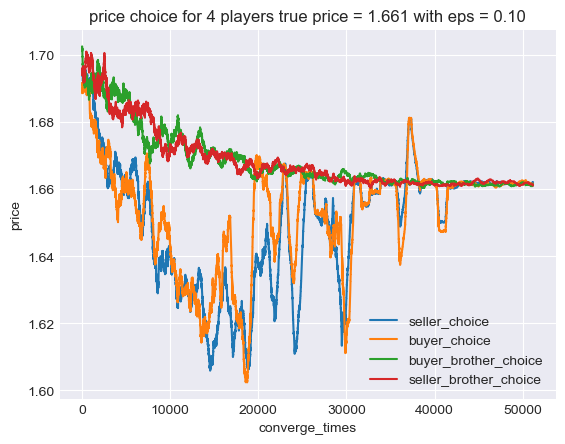

In [125]:
ll = K.state_list.copy()

indexes1 = np.where(~np.isnan(K.state_list[0,:,0]))[0][-1] + 1

for i in range(15):
    ll[ll==i]=K.game.buyer_action_list[i]
    
agree_ab_truth_list1 = np.full((indexes1),np.nan)
disagree_ab_truth_list1 = np.full((indexes1),np.nan)
agree_ab_lies_list1 = np.full((indexes1),np.nan)
disagree_ab_lies_list1 = np.full((indexes1),np.nan)
for i in range(indexes1):
    if i%100000 ==0:
        print(i)
    if i>=1000:
        buyer_list = ll[0,i-1000:i,0]
        buyer_brother_list = ll[0,i-1000:i,1]
        seller_list = ll[0,i-1000:i,2]
        seller_brother_list = ll[0,i-1000:i,3]

                              
        agree_ab_truth_list1[i-1000] = np.mean(buyer_list)
        disagree_ab_truth_list1[i-1000] = np.mean(buyer_brother_list)
        agree_ab_lies_list1[i-1000] = np.mean(seller_list)
        disagree_ab_lies_list1[i-1000] = np.mean(seller_brother_list)
        
plt.style.use('seaborn-darkgrid')
plt.plot(agree_ab_lies_list1)
plt.plot(agree_ab_truth_list1)
plt.plot(disagree_ab_lies_list1)
plt.plot(disagree_ab_truth_list1)
plt.legend(labels=['seller_choice','buyer_choice',\
                  'buyer_brother_choice','seller_brother_choice'],loc='best')
plt.xlabel('converge_times')
plt.ylabel('price')
plt.title('price choice for 4 players true price = %.3f with eps = %.2f'\
          %(K.game.buyer_action_list[int(K.c_index)],0.1))